<a href="https://colab.research.google.com/github/takao8/MLTSAProject/blob/master/HW7/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW7 for PHYS667 - Jon Clifford

In [1]:
!pip install python_speech_features
!pip install PyGithub
!pip install pydub

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=44579b8e6b69a03d4b19bdc40536d107b072399c287e6c5908fafaffb6ceef53
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features
     |████████████████████████████████| 215kB 2.7MB/s 


In [2]:
#system options you will need
import sys
import os
import numpy as np
import glob as glob

import scipy.io.wavfile as wav
from python_speech_features import mfcc
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from scipy.spatial.distance import cdist, euclidean
from scipy.spatial import distance_matrix

import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
np.set_printoptions(threshold=sys.maxsize)
import pylab as pl
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive

drive.mount("/content/gdrive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
cd /content/gdrive/My\ Drive/

/content/gdrive/My Drive


In [0]:
mkdir MLTSA2020

In [6]:
cd MLTSA2020

/content/gdrive/My Drive/MLTSA2020


In [0]:
mkdir data

In [7]:
cd data

/content/gdrive/My Drive/MLTSA2020/data


# **Downloading from External Github repo**

In [0]:
from github import Github
# First create a Github instance:
# we do not need to use username and password because we will access a public repo
g = Github()

In [0]:
guser = g.get_user("salik-a")
repo = guser.get_repo("Speech_Recognition")

In [15]:
wavfiles = repo.get_contents("voices")
#.repos_url#("Speech_Recognition")
wavfiles

[ContentFile(path="voices/Jarvis_template.wav"),
 ContentFile(path="voices/Jarvisd_template.wav"),
 ContentFile(path="voices/Jarvise_template.wav"),
 ContentFile(path="voices/Jarvish_template.wav"),
 ContentFile(path="voices/Jarvisu_template.wav"),
 ContentFile(path="voices/Tofftl_template.wav"),
 ContentFile(path="voices/Tofftld_template.wav"),
 ContentFile(path="voices/Tofftle_template.wav"),
 ContentFile(path="voices/Tofftlh_template.wav"),
 ContentFile(path="voices/Tofftlu_template.wav"),
 ContentFile(path="voices/Tontl_template.wav"),
 ContentFile(path="voices/Tontld_template.wav"),
 ContentFile(path="voices/Tontle_template.wav"),
 ContentFile(path="voices/Tontlh_template.wav"),
 ContentFile(path="voices/Tontlu_template.wav"),
 ContentFile(path="voices/Tontt_template.wav"),
 ContentFile(path="voices/Tonttd_template.wav"),
 ContentFile(path="voices/Tontte_template.wav"),
 ContentFile(path="voices/Tontth_template.wav"),
 ContentFile(path="voices/Tonttu_template.wav"),
 ContentFile(p

In [0]:
path = "https://raw.githubusercontent.com/salik-a/Speech_Recognition/master/"
for f in wavfiles:
    cmd = "wget " + "%s/%s"%(path,f.path)
    os.system(cmd)

In [17]:
cd ../

/content/gdrive/My Drive/MLTSA2020


In [18]:
filenames = np.sort(glob.glob("data/*wav"))
norm_obj= Normalize(vmin=0, vmax=4)
colors = {"Jarvis": (pl.cm.viridis(norm_obj(0)),
                     "Jarvis"),
         "Tofftl": (pl.cm.viridis(norm_obj(1)),
                    "Turn off the lights"),
         "Tontl": (pl.cm.viridis(norm_obj(2)),
                   "Turn on the lights"),
         "Tontt": (pl.cm.viridis(norm_obj(3)),
                   "Turn on the TV"),
         "Ttat": (pl.cm.viridis(norm_obj(4)),
                  "Turn the air temperature")}
y = np.array([[k for k,v in colors.items() for i in range(5)]])[0]
y

array(['Jarvis', 'Jarvis', 'Jarvis', 'Jarvis', 'Jarvis', 'Tofftl',
       'Tofftl', 'Tofftl', 'Tofftl', 'Tofftl', 'Tontl', 'Tontl', 'Tontl',
       'Tontl', 'Tontl', 'Tontt', 'Tontt', 'Tontt', 'Tontt', 'Tontt',
       'Ttat', 'Ttat', 'Ttat', 'Ttat', 'Ttat'], dtype='<U6')

In [10]:
for k,v in colors.items():
        print(k,v)


Jarvis ((0.267004, 0.004874, 0.329415, 1.0), 'Jarvis')
Tofftl ((0.229739, 0.322361, 0.545706, 1.0), 'Turn off the lights')
Tontl ((0.127568, 0.566949, 0.550556, 1.0), 'Turn on the lights')
Tontt ((0.369214, 0.788888, 0.382914, 1.0), 'Turn on the TV')
Ttat ((0.993248, 0.906157, 0.143936, 1.0), 'Turn the air temperature')


# Data Exploration

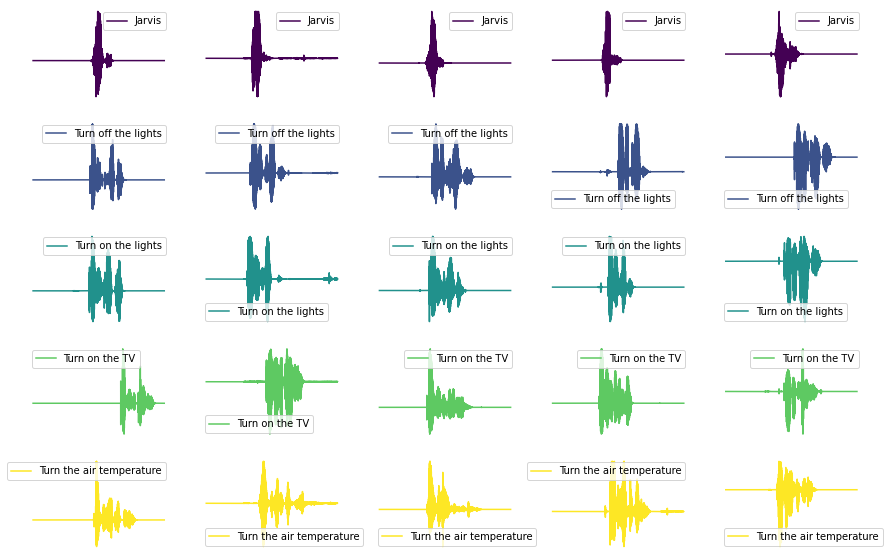

In [19]:
fig = pl.figure(figsize(15, 10))
wavfiles = []
from pydub import AudioSegment
from pydub.playback import play
for i,f in enumerate(filenames):
    ax = fig.add_subplot(5,5,i+1)
    phrase = AudioSegment.from_wav(f)
    play(phrase)
    wavfiles.append(wav.read(f))
    for k,v in colors.items():
        if k in f: 
            color = colors[k][0]
            label = colors[k][1]
    ax.plot(wavfiles[-1][1], label=label, color=color)
    ax.axis('off')              
    pl.legend()

Figure 1: (Description by Professor Bianco) 25 sound bites read in as arrays from the original .wav file. The arrays represnet sound intensity vs time, but the spectral sound information (frequency) is lost. These are therefore simplified representations of the original data. Each of 5 sentences is recorded as spoken by a different person in a different environment: the word "Jarvis", the sentences "Turn off the lights", "Turn on the lights", "Turn on the TV", and "Turn the air temperature". In the above plot, each row is a different sentence (also plotted with a different color). The content of the soundbite is written on top of the wave plot. At a glance, the soundbites show some similarities within the same sentence, mostly in the duration of the speech. We also note that the starting point of the speech is not homogeneous within the recorded segment.

In [20]:
wavfiles = np.array([w[1] for w in wavfiles])
print ("the size of the full data set is :", wavfiles.shape)

the size of the full data set is : (25, 64000)


# Downsampling

wavfiles[0].shape[0]

In [432]:
wavfiles[0].shape[0]**2

4096000000

There are 8e9 bits in a gigabyte, and 8e6 bytes in a megabyte.  With that in mind, we can calculate the amount of memory required to create a distance matrix with the file sizes that we have:

In [21]:
print("calculating a distance matrix for the full files would requires " + 
      f"{wavfiles[0].shape[0]**2*64/8e9} GB of memory")
print("subsampling by a factor 10 requires " + 
      f"{wavfiles[0][::8].shape[0]**2*64/8e9} GB of memory")
print("subsampling by a factor 10 requires " + 
      f"{wavfiles[0][::10].shape[0]**2*64/8e9} GB of memory")
print("subsampling by a factor 100 requires " + 
      f"{wavfiles[0][::100].shape[0]**2*64/8e6} MB of memory")


calculating a distance matrix for the full files would requires 32.768 GB of memory
subsampling by a factor 10 requires 0.512 GB of memory
subsampling by a factor 10 requires 0.32768 GB of memory
subsampling by a factor 100 requires 3.2768 MB of memory


That's a lot, so we're going to sample down.

In [0]:
steps = 10

In [0]:
X = preprocessing.scale(wavfiles[:,::steps], axis=1)

In [24]:
X.shape, X.std(axis=1)

((25, 6400),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]))

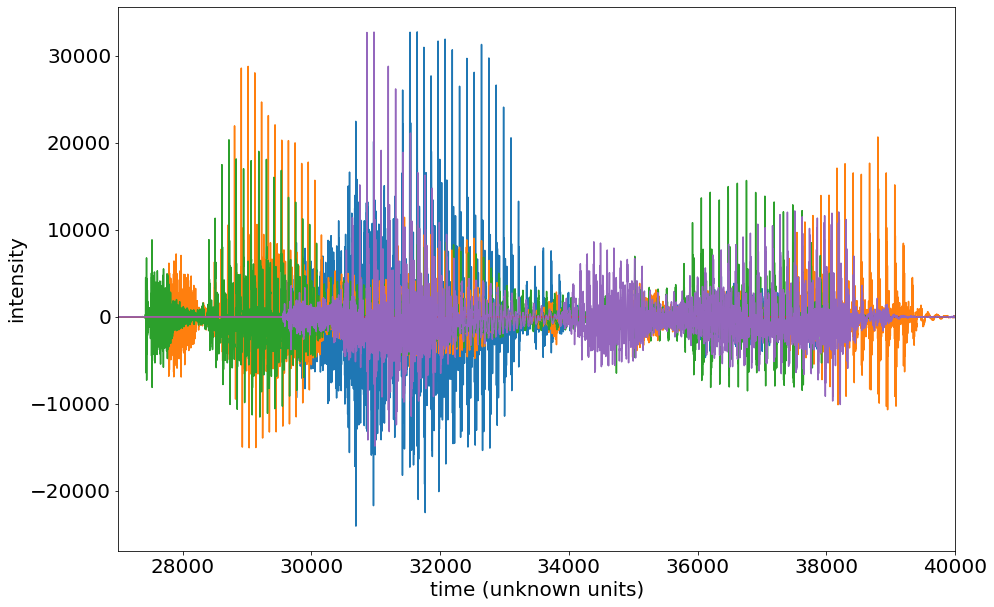

In [25]:
pl.rcParams['font.size'] = 20
pl.plot(wavfiles[0])
pl.plot(wavfiles[5])
pl.plot(wavfiles[10])
pl.plot(wavfiles[15])
pl.plot(wavfiles[20])
pl.xlim(27000, 40000)
pl.xlabel("time (unknown units)", fontsize=20)
pl.ylabel("intensity", fontsize=20);

Figure 2: The first soundbite of each sentence, plotted for elements 27000-40000 out of 64000.

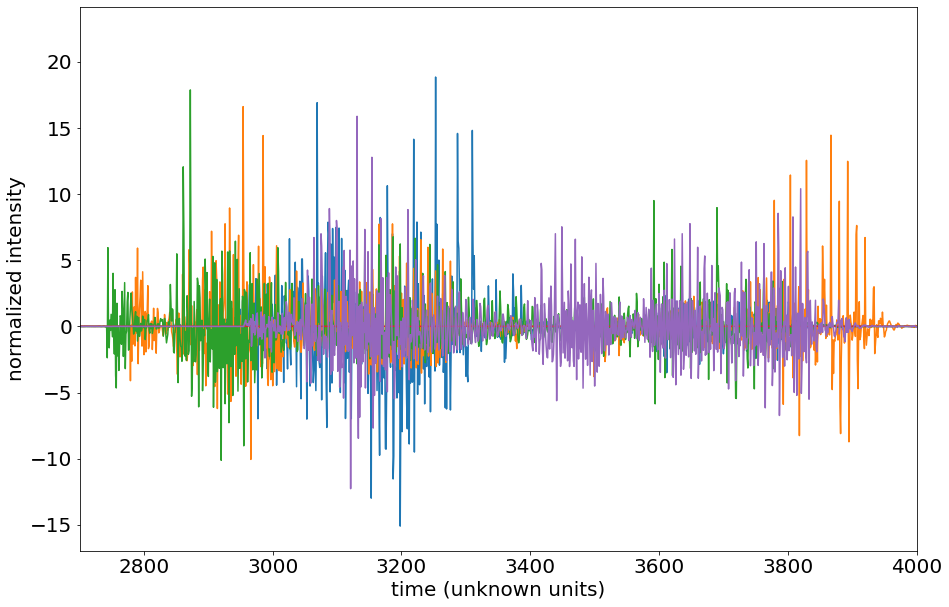

In [26]:
pl.rcParams['font.size'] = 20
pl.plot(X[0])
pl.plot(X[5])
pl.plot(X[10])
pl.plot(X[15])
pl.plot(X[20])
pl.xlim(2700, 4000)
pl.xlabel("time (unknown units)", fontsize=20)
pl.ylabel("normalized intensity", fontsize=20);

Figure 3: The same as Figure 2 except with standardized arrays and downsampled by selecting every 10th datapoint.

# Calculate Distance

In [0]:
def naive_distances(a, b):
    return (a - b).sum()
def l1(a, b):
    return (np.abs(a - b)).sum()


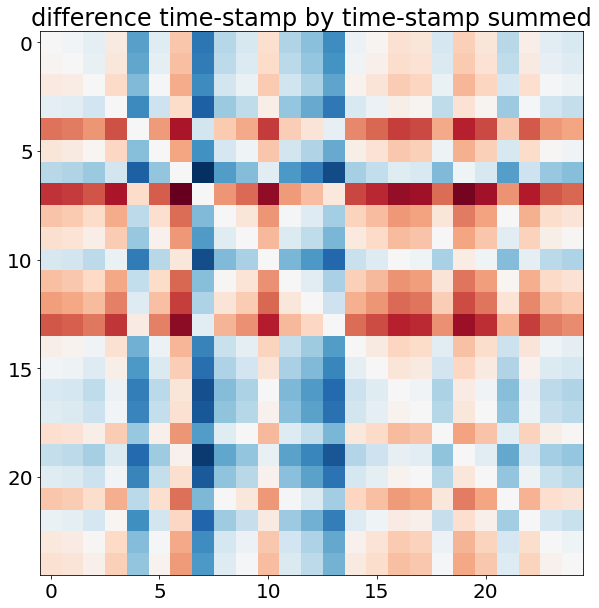

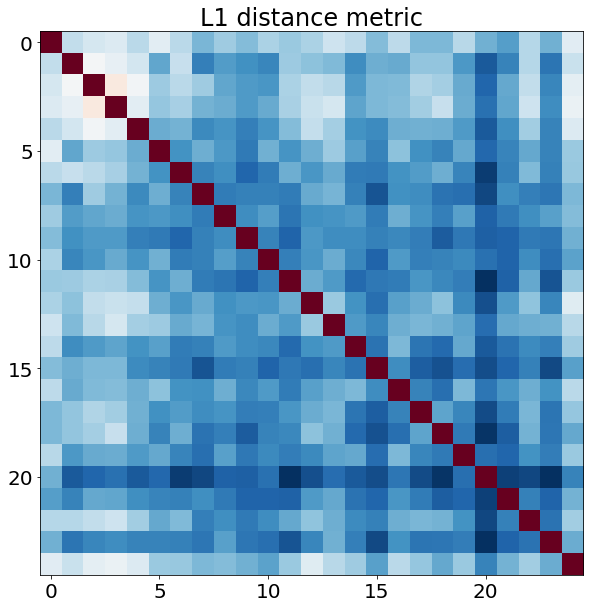

In [28]:
pl.imshow(cdist(X[:,::steps], 
               X[:,::steps], metric=naive_distances), 
         cmap="RdBu")
pl.title("difference time-stamp by time-stamp summed")
pl.figure()
pl.imshow(cdist(X[:,::steps], 
               X[:,::steps], metric=l1), 
         cmap="RdBu")
pl.title("L1 distance metric");

Figure 4: Distances of all time series with respect to each other based on the naive distance of the difference in the datapoints (top plot) and the L1 metric (bottom plot).  Note that with the naive distance, we can have negative values, thus any form of relationship is virtually impossible to see, while in the L1 metric we can clearly see the 0 values along the diagonal corresponding to the distances of the series with themselves.

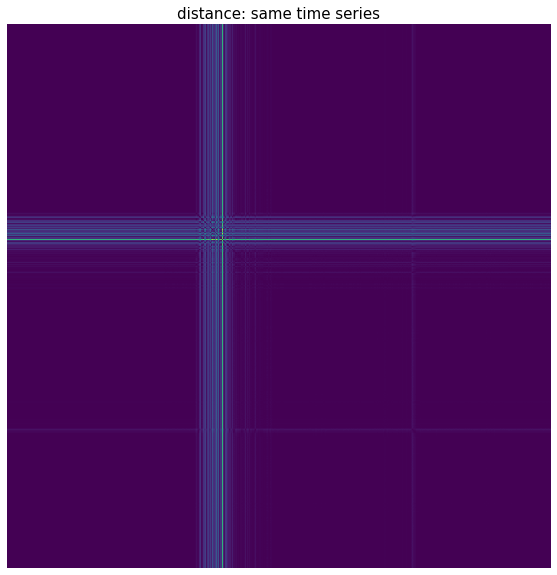

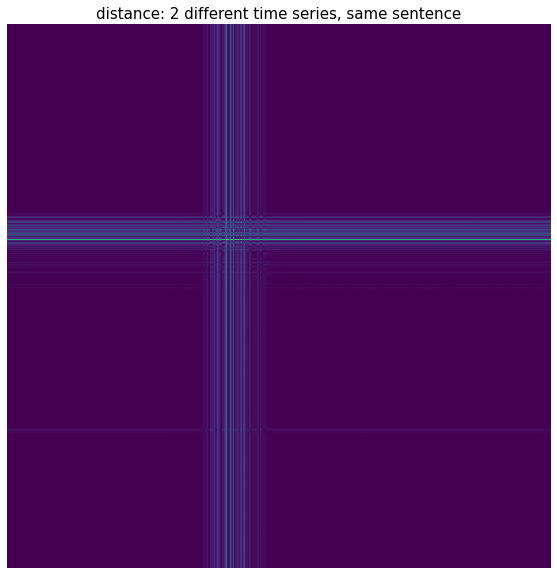

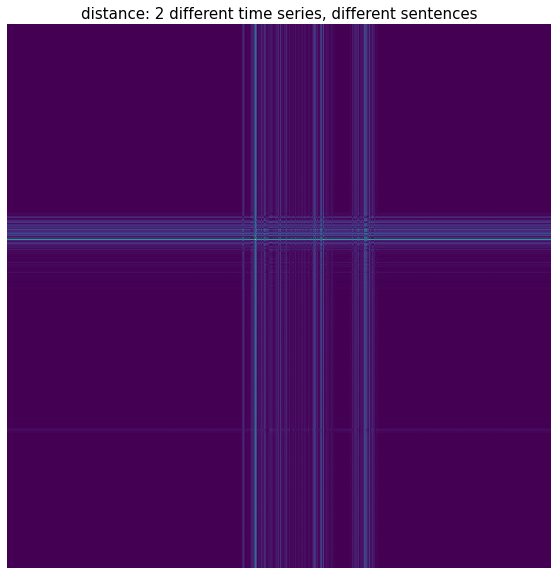

In [29]:
pl.imshow(cdist(np.atleast_2d(X[1][::steps]).T, 
                np.atleast_2d(X[1][::steps]).T,
      metric=l1))
pl.title("distance: same time series", fontsize=15)
pl.axis('off')
pl.figure()
pl.imshow(cdist(np.atleast_2d(X[1][::steps]).T, 
                np.atleast_2d(X[2][::steps]).T,
      metric=l1))
pl.title("distance: 2 different time series, same sentence", fontsize=15);
pl.axis('off')
pl.figure()
pl.imshow(cdist(np.atleast_2d(X[1][::steps]).T, 
                np.atleast_2d(X[10][::steps]).T,
      metric=l1))
pl.title("distance: 2 different time series, different sentences", 
         fontsize=15);
pl.axis('off');

Figure 5: Distance plots with the L1 metric of our time series over different situations: top indicating a series with itself, the middle indicating two different time series but of the same sentence, and the bottom indicating two different time series with different sentences.  Note that the figures are virtually incomprehensible, and are adjusted for the next figure.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


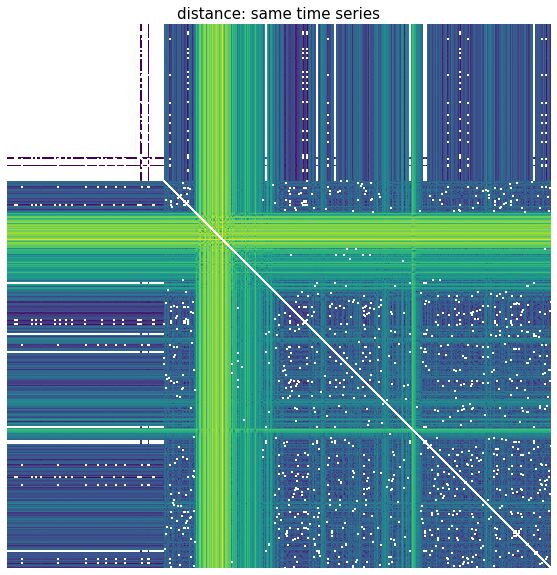

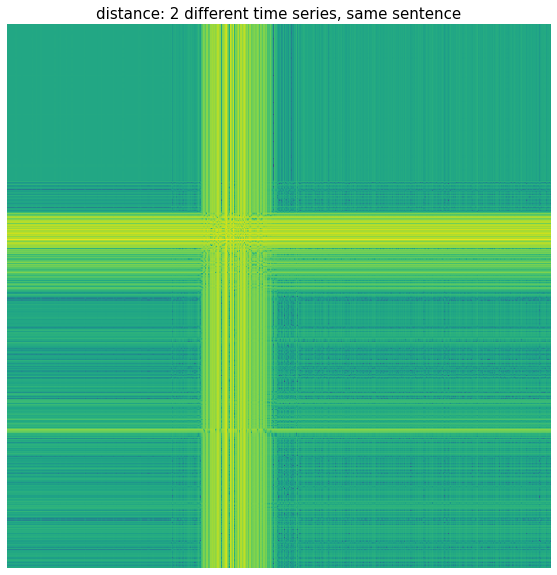

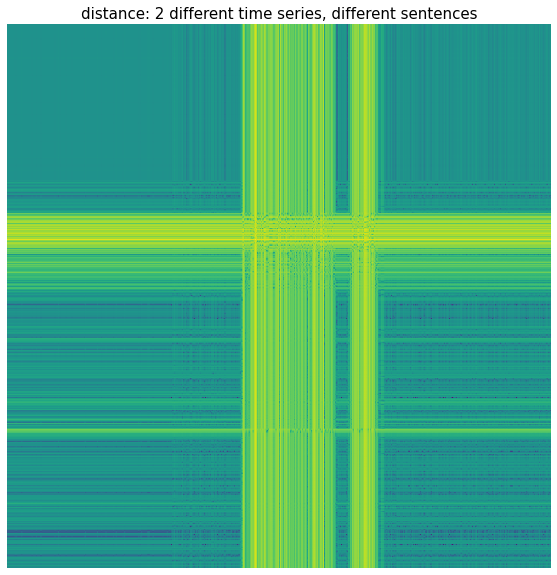

In [30]:
pl.imshow(np.log10(cdist(np.atleast_2d(X[1][::steps]).T, 
                np.atleast_2d(X[1][::steps]).T,
      metric=l1)))
pl.title("distance: same time series", fontsize=15)
pl.axis('off')
pl.figure()
pl.imshow(np.log10(cdist(np.atleast_2d(X[1][::steps]).T, 
                np.atleast_2d(X[2][::steps]).T,
      metric=l1)))
pl.title("distance: 2 different time series, same sentence", fontsize=15);
pl.axis('off')
pl.figure()
pl.imshow(np.log10(cdist(np.atleast_2d(X[1][::steps]).T, 
                np.atleast_2d(X[10][::steps]).T,
      metric=l1)))
pl.title("distance: 2 different time series, different sentences", 
         fontsize=15);
pl.axis('off');

Figure 6: The same as figure 5, with log10-scaled values to illustrate the relationships in the difference matricies.  The cross likely indicates the point in the series where the individual spoke, and is the point in our series that will need to be analyzed with DTW to determine the similarity of two different series, as talking speed, tone, and pitch can stretch or amplify the values in the series that otherwise should be similar.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


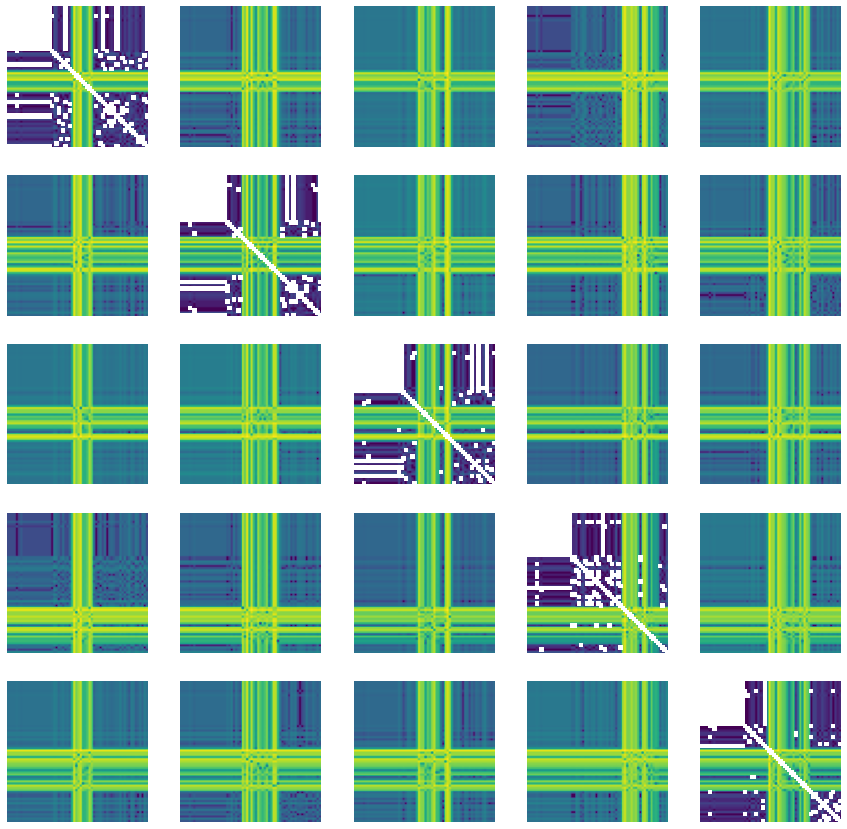

In [31]:


restep = 100
fig = pl.figure(figsize(15, 15))

for i in range(0,25,5):
    for k, j in enumerate(range(0,25,5)):
        ax = fig.add_subplot(5,5,i + k + 1)
        pl.imshow(np.log10(cdist(np.atleast_2d(X[i][::restep]).T, 
                np.atleast_2d(X[j][::restep]).T, 
          metric=(lambda x,y: np.abs(x - y)))))
        pl.axis('off');



Figure 7: Similar to Figure 6 but with all sound bites, and the series compressed by another factor of 10.

# DTW Distance

Now we'll code our DTW algorithm.

In [0]:
def path(DTWm):
  # the path can be calculated backword or forward
  # I find bacward more intuitive
  # start at one to the last cell:
  i, j = np.array(DTWm.shape) - 2

  #since I do not know how long the path is i will use lists
  # p and q will be the list of indices of the path element along the 2 array axes
  p, q = [i], [j]
  # go all the way to cell 0,0
  while (i > 0) or (j > 0):
      	# pick minimum of 3 surrounding elements: 
      	# the diagonal and the 2 surrounding it
        tb = argmin((DTWm[i, j], DTWm[i, j+1], DTWm[i+1, j]))
        #stay on the diagonal
        if tb == 0:
            i -= 1
            j -= 1
        #off diagonal choices: move only up or sideways
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        # put i and the j indexx into p and q pushing existing entries forward
        p.insert(0, i)
        q.insert(0, j)
  return array(p), array(q)

Above is the code that professor Bianco typed, and below is my version of DTW.  For now I understand that it's inefficient, but I'll try to improve it before submitting this homework.

In [0]:
def dtw(v1, v2, show=False):
  """
  DTW algorithm comparing the similarity of series v1 and v2
  v1: first series 
  v2: second series
  show: parameter to decide whether to plot the distance matrix between v1 and v2

  OUTPUT:
  a[-1][-1]: the last value of our DTW matrix
  a: our resulting dtw matrix
  (q, p): the path resulting from Professor Bianco's algorithm above when 
    supplied the DTW matrix a.
  """
  l = cdist(np.atleast_2d(v1).T, 
                np.atleast_2d(v2).T, metric=l1)
  a = np.zeros((len(v1), len(v2)))
  a[0][0] = l[0][0]
  a[1][0] = l[1][0]
  a[0][1] = l[0][1]
  i, j = 1, 1

  for i in range(1, len(v1)):
    a[i, 0] = l[i, 0] + a[i-1, 0]
  for j in range(1, len(v2)):
    a[0, j] = l[0, j] + a[0, j-1]
  
  for i in range(1, len(v1)):
    for j in range(1, len(v2)):
      a[i, j] = l[i, j] + min(a[i][j-1], a[i-1][j], a[i-1][j-1])
      #a[j, i] = a[i, j]

  q, p = path(a)

  if show==True:
    pl.clf() 
    pl.imshow(np.log10(a))
    pl.plot(q, p, 'k', linewidth=3)
    pl.figure(figsize(10, 10))
  return a[-1][-1], a, (q, p)

And below we'll show some results of our algorithm.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


dtw distance:  0.0


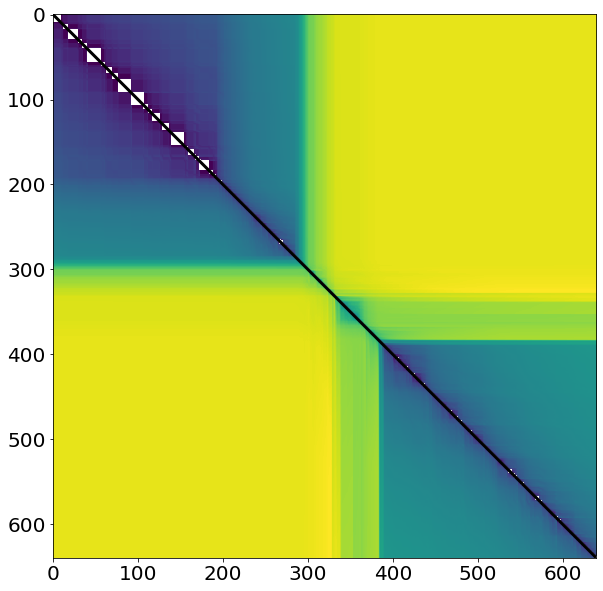

<Figure size 720x720 with 0 Axes>

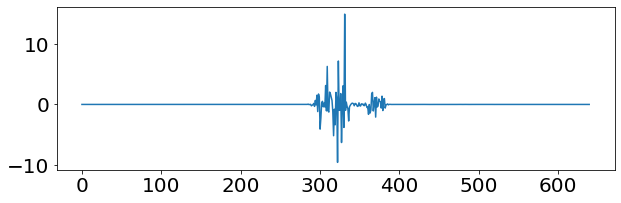

In [394]:
restep=10
print("dtw distance: ", dtw(X[0][::restep], X[0][::restep], show=True)[0]);
pl.figure(figsize(10,3))
pl.plot(X[0][::restep]);

Figure 8: The DTW matrix and the optimal path for the first series against itself.  Note that all entries on the diagonal are 0, thus the path should be along the diagonal and the resulting cost should be 0.

dtw distance:  121.55413980041301


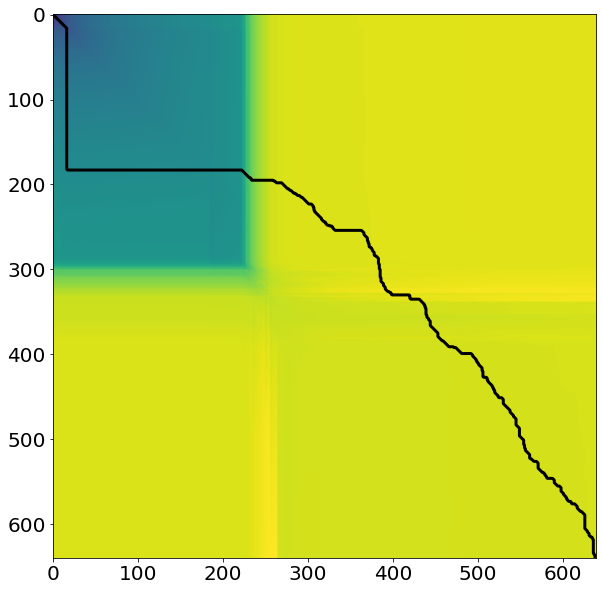

<Figure size 720x720 with 0 Axes>

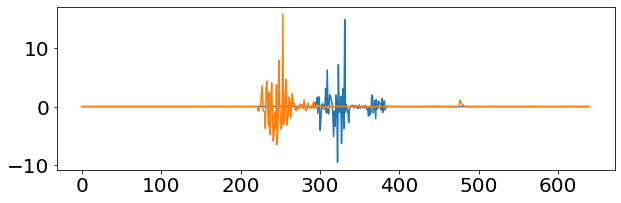

In [433]:
# DTW distance to a file with a different sound bite, normalized
print("dtw distance: ", dtw(X[0][::restep], X[1][::restep], show=True)[0])
pl.figure(figsize(10,3))
pl.plot(X[0][::restep])
pl.plot(X[1][::restep]);

Figure 9: Similar to Figure 8, but with the result DTW of the 1st series against the 2nd series.  Note that the path is no longer directly across the diagonal, since the diagonal will be non-zero.  The bottom plot shows the time series plotted on the same graph.

dtw distance:  216485.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


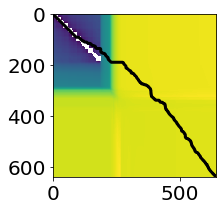

<Figure size 720x720 with 0 Axes>

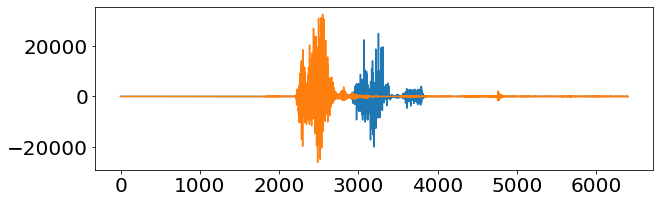

In [442]:
# DTW distance to a file with a different sound bite, normalized
print("dtw distance: ", dtw(wavfiles[0][::steps*restep], wavfiles[1][::steps*restep], show=True)[0])
pl.figure(figsize(10,3))
pl.plot(wavfiles[0][::restep])
pl.plot(wavfiles[1][::restep])

Figure 10: Similar to Figure 9, with two different series.

dtw distance:  150.50888976161608


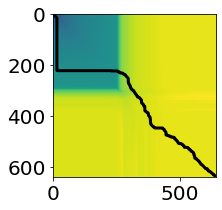

<Figure size 720x720 with 0 Axes>

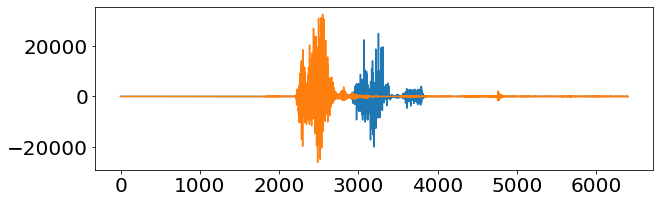

In [408]:
# DTW distance to a file with a different sound bite
print("dtw distance: ", dtw(X[0][::restep], X[24][::restep], show=True)[0])
pl.figure(figsize(10,3))
pl.plot(wavfiles[0][::restep])
pl.plot(wavfiles[1][::restep])

Figure 11: Similar to Figures 9 and 10, but again with 2 different series.

# Nearest Neighbor of First Soundbite

In the following code, we'll determine the nearest neightbor of a certain soundbite.  When comparing soundbites, we should find that soundbites that say the same word are the most similar to each other.  Using our DTW, we'll try to verify this.

In [398]:
# what is most similar to the first time series? (other than itself)
distances = np.zeros(25) * np.nan
for i in range(25):
    print(i, "/25")
    distances[i], _, _ = dtw(X[0][::restep], X[i][::restep]);

0 /25
1 /25
2 /25
3 /25
4 /25
5 /25
6 /25
7 /25
8 /25
9 /25
10 /25
11 /25
12 /25
13 /25
14 /25
15 /25
16 /25
17 /25
18 /25
19 /25
20 /25
21 /25
22 /25
23 /25
24 /25


In [399]:
distances.argsort()

array([ 0,  3,  2,  1, 24, 13,  4,  5,  8, 22, 19, 15,  6, 16, 11, 12, 18,
        7,  9, 17, 10, 14, 23, 20, 21])

In [400]:
print("Based on its nearest neighbor the first sound bite says...")
print(y[distances.argsort()[1]])

Based on its nearest neighbor the first sound bite says...
Jarvis


This is consistent with what Professor Bianco obtained.

# Task 4:

In [409]:
# what is most similar to the first time series? (other than itself)
distancesE = np.zeros(25) * np.nan
for i in range(25):
    print(i, "/25")
    distancesE[i] = euclidean(X[19], X[i]);

0 /25
1 /25
2 /25
3 /25
4 /25
5 /25
6 /25
7 /25
8 /25
9 /25
10 /25
11 /25
12 /25
13 /25
14 /25
15 /25
16 /25
17 /25
18 /25
19 /25
20 /25
21 /25
22 /25
23 /25
24 /25


In [410]:
distancesE.argsort()

array([19,  0, 11, 18,  8, 12,  6, 16,  2, 14, 22,  3, 17, 21,  1,  4, 13,
        9, 10, 15,  5, 23, 24, 20,  7])

In [416]:
print("Based on its nearest neighbor and Euclidian distance ",
      "the last sound bite says...")
print(y[distancesE.argsort()[1]])
print("Correct!") if y[distancesE.argsort()[1]] == y[19] else print("Sorry...")

Based on its nearest neighbor and Euclidian distance  the last sound bite says...
Jarvis
Sorry...


In [429]:
# what is most similar to the first time series? (other than itself)
distancesDTW = np.zeros(25) * np.nan
for i in range(25):
    print(i, "/25")
    distancesDTW[i], _, _ = dtw(X[19][::steps], X[i][::steps])

0 /25
1 /25
2 /25
3 /25
4 /25
5 /25
6 /25
7 /25
8 /25
9 /25
10 /25
11 /25
12 /25
13 /25
14 /25
15 /25
16 /25
17 /25
18 /25
19 /25
20 /25
21 /25
22 /25
23 /25
24 /25


In [430]:
print("Based on its nearest neighbor and DTW distance ",
      "the last sound bite says...")
print(y[distancesDTW.argsort()[1]])
print("Correct!") if y[distancesDTW.argsort()[1]] == y[19] else print("Sorry...")

Based on its nearest neighbor and DTW distance  the last sound bite says...
Tofftl
Sorry...


# Verifying with tslearn

I removed this section from the homework, since I had to adjust the DTW algorithm based on Professor Bianco's specifics for how to code the algorithm.  When I originally coded the DTW algorithm, I found that the results were consistent with what I obtained in tslearn.  However, the results were inconsistent with the Professor's.  I adjusted the algorithm to get the same as the Professor, but now they're inconsistent with tslearn.

I'll leave the remenants of what I got in this notebook, but note that the results of my old dtw() function in this section do not reflect what I get with my new dtw() function.

------------------------------

------------------------------

In [239]:
pip install tslearn

First, recall our result:

In [243]:
print("dtw distance: ", dtw(X[0][::restep], X[1][::restep], show=True)[0]);

dtw distance:  22.476840713812607


And now tslearn:

In [0]:
from tslearn.metrics import dtw as dtw2
cost = dtw2(X[0][::restep], X[1][::restep], global_constraint="sakoe_chiba", sakoe_chiba_radius=1)

In [242]:
cost

6.875695146130345

The difference can be explained by the fact they use Euclidian.  We'll change the algorithm slightly:

In [0]:
def dtweucl(v1, v2, show=False):
  l = cdist(np.atleast_2d(v1).T, 
                np.atleast_2d(v2).T, metric=l1)
  a = np.zeros((len(v1), len(v2)))
  a[0][0] = l[0][0]**2
  a[1][0] = l[1][0]**2
  a[0][1] = l[0][1]**2
  i, j = 1, 1
  while i < len(v1)-1 or j < len(v2)-1:
    a[i][j] = l[i][j]**2 + min(a[i][j-1], a[i-1][j], a[i-1][j-1])
    a[i+1][j] = l[i+1][j]**2 + min(a[i][j], a[i][j-1])
    a[i][j+1] = l[i][j+1]**2 + min(a[i][j], a[i-1][j])
    i += 1
    j += 1
  a[-1][-1] = l[-1][-1]**2 + min(a[-1][-2], a[-2][-1], a[-2][-2])
  return np.sqrt(a[-1][-1]), a

And calculate it again:

In [246]:
print("dtw distance: ", dtweucl(X[0][::restep], X[1][::restep], show=True)[0]);

dtw distance:  6.875693562748539


This is the exact result as what tslearn returns.  Thus, our results are consistent.